In [4]:
import numpy as np
import matplotlib.pyplot as plt

#np.random.seed(40)

# Import data
path = r'C:\Users\Marcus\Downloads'
y = np.genfromtxt(path + '/seOMXlogreturns2012to2014.csv')

In [53]:
# Static parameters
phi = 0.98
sigma = 0.16
Beta = [0.1, 0.25, 0.5, 1.0, 2.0] # Vary beta between 0 and 2

def gaussian_density(x, mu=0.0, sigma=1.0):
    return 1/np.sqrt(2 * np.pi * sigma**2) * np.exp(-0.5*((x - mu)/sigma)**2 )

In [55]:
def bootstrap_particle_filter(y, n_particles, theta):
    phi = theta[0] 
    sigma = theta[1] 
    beta = theta[2]
    
    T = len(y)
    x = np.random.normal(0.0, 1.0, size=n_particles)
    w = np.ones(n_particles) / n_particles
    #w_tilde = np.zeros(n_particles)
    
    X = np.zeros([T, n_particles])
    W = np.zeros([T, n_particles])
    W_tilde = np.zeros([T, n_particles])
    for t in range(T): # Fix indexing!
        
        # Sample indeces
        a = np.random.choice(n_particles, n_particles, p=w)
        
        # Sample particles
        x = np.random.normal(loc=phi*x[a], scale=sigma)
        
        #for i in range(n_particles):
        w_tilde = gaussian_density(y[t], 0.0, np.sqrt(beta**2 * np.exp(x)) )
            
        w = w_tilde / np.sum(w_tilde)
        
        X[t, :] = x
        W[t, :] = w
        W_tilde[t, :] = w_tilde # used for computing the log-likelihood
    return X, W, W_tilde

In [56]:
def compute_log_likelihood(w_tilde):
    N = w_tilde.shape[-1] 
    return np.sum( np.log(np.sum(w_tilde, axis=1)) - np.log(N) )

In [ ]:
n_runs = 10
logl_list = []

N = 1000

for i, beta in enumerate(Beta):
    print(beta)
    theta = [phi, sigma, beta]
    logl_beta = []
    for j in range(n_runs):
        _, _, w_tilde = bootstrap_particle_filter(y, N, theta)
        #print(w[-1,:10])
        logl = compute_log_likelihood(w_tilde)
        #print("Log-likelihood: ", logl)
        logl_beta.append(logl)
    logl_list.append(logl_beta)

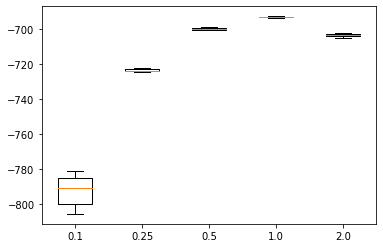

In [60]:
# Plot boxplot
beta_list = [str(b) for b in Beta]
plt.boxplot(logl_list, showfliers=False, labels=beta_list)
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

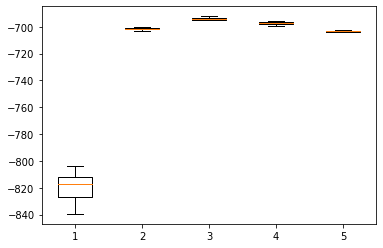

In [33]:
plt.boxplot(logl_list, showfliers=False)
plt.show()